In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
%matplotlib inline
plt.rcParams.update({'font.size': 20})
from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter
import nibabel as nib
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from scipy.fftpack import fft,fftshift,ifft
import tqdm
import matplotlib

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals = supercluster_signals.T
supercluster_signals.shape

(30456, 501)

In [3]:
supercluster_signals_fly = np.reshape(supercluster_signals,([9,3384,501]))

In [4]:
### for a given supercluster, i need to know the original median z-depth for each fly ###

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']

z_corrections = []
for fly in tqdm.tqdm(fly_names):
    to_load = os.path.join(dataset_path, fly, 'warp', '20201220_warped_z_depth.nii')
    z_corrections.append(np.array(nib.load(to_load).get_data(), copy=True))
z_corrections = np.asarray(z_corrections)

superclusters_3d = np.load(os.path.join(cluster_dir, "20221130_pca_clsuters_in_luke_OG.npy"))
superclusters_3d = superclusters_3d[...,::-1] ### FLIP Z !!!!!!!!!!!!
superclusters_3d.shape

original_z_depth = []
for fly in tqdm.tqdm(range(9)):
    for cluster in range(501):
        ind = np.where(superclusters_3d==cluster)
        original_z_depth.append(np.median(z_corrections[fly,ind[0],ind[1],ind[2]]))
original_z_depth = np.asarray(original_z_depth)
original_z_depth = np.reshape(original_z_depth,(9,501))
original_z_depth = original_z_depth.astype('int')

100%|██████████| 9/9 [00:23<00:00,  2.64s/it]


In [5]:
### maybe the easiest way to do this is have a single behavior trace at original res (50Hz)
### I think it will be safest to use the raw neural data (not interpolated) and assign to bins

In [6]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [7]:
fictrac = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)

In [8]:
fictrac_timestamps = np.arange(0,30*60*1000,20)
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [9]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9):
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [10]:
xs = np.arange(0,532*40,532)+(532/2)
xs = np.concatenate((xs[::-1]*-1, xs))

In [11]:
for fly in range(9):
    print(F"{len(peaks_all_fly[fly]['L'])}; {len(peaks_all_fly[fly]['R'])}")
    #print(len(peaks_all_fly[fly]['L'])+len(peaks_all_fly[fly]['R']))
    
# a=0
# b=0
# for fly in range(9):
#     a+=len(peaks_all_fly[fly]['L'])
#     b+=len(peaks_all_fly[fly]['R'])
# print(F"Total {a}; {b}")

#[0,3,4,6,7,8]


222; 519
38; 33
140; 2
47; 105
178; 291
27; 543
364; 601
276; 219
70; 111


In [12]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################

neural_traces_all_fly = []
for fly in range(9):
    neural_traces = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
    for cluster in [77,327]:
        z = original_z_depth[fly,cluster]
        neural_timestamps_cluster = neural_timestamps[:,z]
        for beh in ['L', 'R']:
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            for peak in peaks_in_ms:
                #this will give the index of the first neural data after the peak
                # 40 index will be the bin from 0 to 532ms after the peak
                middle = np.searchsorted(neural_timestamps_cluster,peak) 
                neural_traces[F"{beh}{cluster}"].append(supercluster_signals_fly[fly,middle-40:middle+40,cluster])
            neural_traces[F"{beh}{cluster}"] = np.asarray(neural_traces[F"{beh}{cluster}"])
    neural_traces_all_fly.append(neural_traces)
    
neural_traces_all_fly_stack = {'L77': [], 'R77': [], 'L327': [], 'R327': []}
for signal in ['L77','R77','L327','R327']:
    for fly in range(9):
        neural_traces_all_fly_stack[signal].extend(neural_traces_all_fly[fly][signal])
    neural_traces_all_fly_stack[signal] = np.asarray(neural_traces_all_fly_stack[signal])

Ttest_indResult(statistic=-4.536936278872314, pvalue=5.884834504858544e-06)
-0.01204497331252804 0.005592925182573299


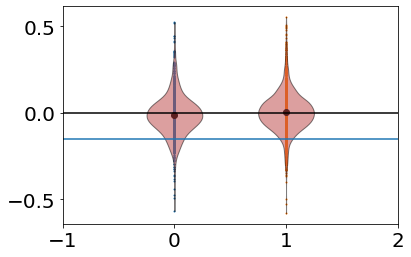

In [13]:
start = 13
stop = 25

plt.axhline(0,color='k')
ax = plt.gca()

a = neural_traces_all_fly_stack['L77'][:,start:stop] - neural_traces_all_fly_stack['L327'][:,start:stop]
a = np.mean(a,axis=1)
plt.scatter([0]*len(a),a,s=1)
plt.scatter([0],np.mean(a),color='k')
parts = ax.violinplot(a,positions=[0],showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('#BB4141')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)
    pc.set

b = neural_traces_all_fly_stack['R77'][:,start:stop] - neural_traces_all_fly_stack['R327'][:,start:stop]
b = np.mean(b,axis=1)
plt.scatter([1]*len(b),b,s=1)
plt.scatter([1],np.mean(b),color='k')
parts = ax.violinplot(b,positions=[1],showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('#BB4141')
    pc.set_edgecolor('black')
    pc.set_alpha(.5)
    pc.set

plt.xlim(-1,2)

plt.axhline(-.15)

print(scipy.stats.ttest_ind(a, b))
print(np.mean(a),np.mean(b))

In [14]:
pre_beh = {'L':[],'R':[]}
for fly in range(9):
    for signal in ['L','R']:
        for peak in peaks_all_fly[fly][signal]:
            beh = fictrac[fly][peak-1500:peak+1500]
            pre_beh[signal].append(beh)

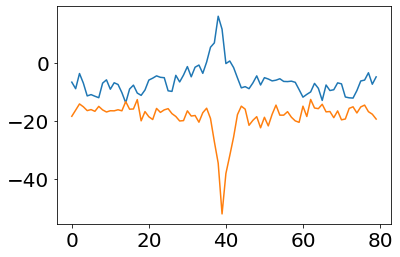

In [15]:
beh_traces = {}

high_res_tp = np.arange(-30000,30000,20)

xs = np.arange(0,532*40,532)+(532/2)
xs = np.concatenate((xs[::-1]*-1, xs))
low_res_tp = xs


obj = interp1d(high_res_tp,pre_beh['L'],bounds_error=False)
beh_traces['L'] = obj(low_res_tp)
plt.plot(np.mean(beh_traces['L'],axis=0))

obj = interp1d(high_res_tp,pre_beh['R'],bounds_error=False)
beh_traces['R'] = obj(low_res_tp)
plt.plot(np.mean(beh_traces['R'],axis=0))

In [23]:
len(pre_beh['L']), len(pre_beh['R'])

(1362, 2424)

In [27]:
np.asarray(pre_beh['L']).shape

(1362, 3000)

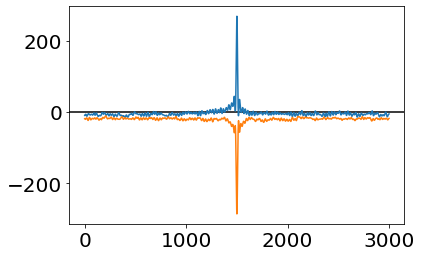

In [20]:
plt.axhline(0,color='k')
meantrace_L = np.mean(np.asarray(pre_beh['L']),axis=0)
plt.plot(meantrace_L)
meantrace_R = np.mean(np.asarray(pre_beh['R']),axis=0)
plt.plot(meantrace_R)
#plt.xlim(900,1100)
#plt.axvline(987)

In [16]:
neural_traces = {}
neural_traces['L'] = neural_traces_all_fly_stack['L77'] - neural_traces_all_fly_stack['L327']
neural_traces['R'] = neural_traces_all_fly_stack['R77'] - neural_traces_all_fly_stack['R327']

In [17]:
neural_traces['L'].shape, beh_traces['L'].shape

((1362, 80), (1362, 80))

In [ ]:
### this is looking good; next I just need to do the binning

In [18]:
np.mean(neural_traces['L'][:,13:25],axis=1).shape

(1362,)

In [24]:
bins = 

Text(0, 0.5, 'beh')

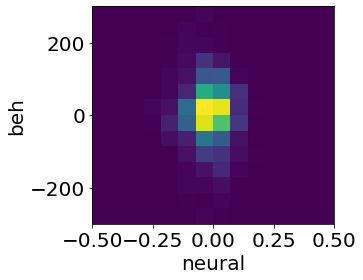

In [38]:
a = np.mean(neural_traces['L'][:,13:25],axis=1)
b = np.mean(beh_traces['L'][:,13:25],axis=1)

x_bins = np.linspace(-.5,.5,15)
y_bins = np.linspace(-300,300,15)

out = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
plt.imshow(out,extent=[-.5,.5,-300,300],aspect=.0015)
plt.xlabel('neural')
plt.ylabel('beh')

Text(0, 0.5, 'beh')

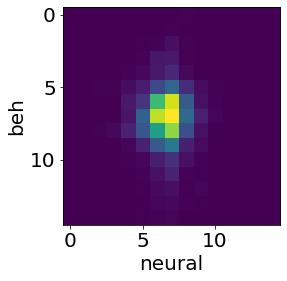

In [20]:
#[[xmin, xmax], [ymin, ymax]]
a = np.mean(neural_traces['R'][:,13:25],axis=1)
b = np.mean(beh_traces['R'][:,13:25],axis=1)

out = np.histogram2d(a, b, bins=15, range=[[-.5, .5], [-300, 300]])[0]
plt.imshow(out)
plt.xlabel('neural')
plt.ylabel('beh')

Text(0, 0.5, 'beh')

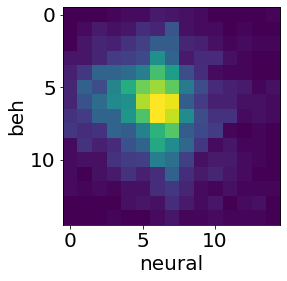

In [21]:
out = np.histogram2d(neural_traces['R'][:,39], beh_traces['R'][:,39], bins=15, range=[[-.5, .5], [-300, 300]])[0]
plt.imshow(out)
plt.xlabel('neural')
plt.ylabel('beh')

Text(0, 0.5, 'beh')

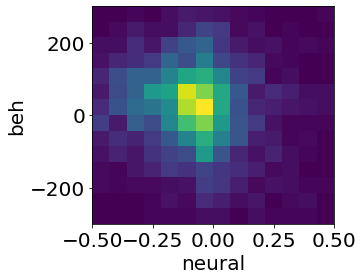

In [43]:
a = np.mean(neural_traces['R'][:,39:40],axis=1)
b = np.mean(beh_traces['R'][:,39:40],axis=1)

x_bins = np.linspace(-.5,.5,15)
y_bins = np.linspace(-300,300,15)

out = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
plt.imshow(out,extent=[-.5,.5,-300,300],aspect=.0015)
plt.xlabel('neural')
plt.ylabel('beh')

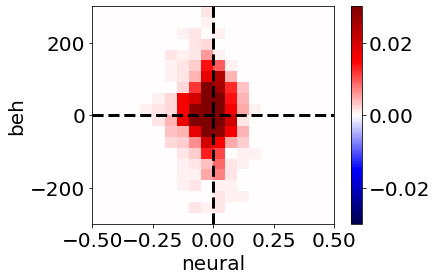

In [163]:
tp1 = 13
tp2 = 25

# tp1 = 38
# tp2 = 41

# tp1 = 50
# tp2 = 70

x_bins = np.linspace(-.5,.5,21)
y_bins = np.linspace(-300,300,21)

a = np.mean(neural_traces['L'][:,tp1:tp2],axis=1)
b = np.mean(beh_traces['L'][:,tp1:tp2],axis=1)
hist_L = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
hist_L/=len(a)

a = np.mean(neural_traces['R'][:,tp1:tp2],axis=1)
b = np.mean(beh_traces['R'][:,tp1:tp2],axis=1)
hist_R = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
hist_R/=len(a)

plt.imshow((hist_L),extent=[-.5,.5,-300,300],aspect=.0015,cmap='seismic',vmin=-.03,vmax=.03)

plt.xlabel('neural')
plt.ylabel('beh')
plt.colorbar()
ax = plt.gca()
#ax.invert_xaxis()

plt.axvline(0,color='k',lw=3,linestyle='--')
plt.axhline(0,color='k',lw=3,linestyle='--')

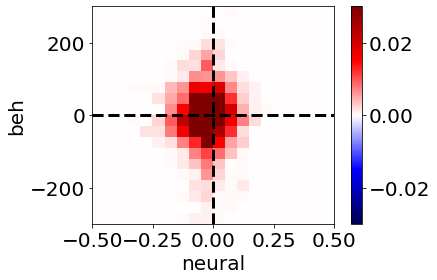

In [164]:
tp1 = 13
tp2 = 25

# tp1 = 38
# tp2 = 41

# tp1 = 50
# tp2 = 70

x_bins = np.linspace(-.5,.5,21)
y_bins = np.linspace(-300,300,21)

a = np.mean(neural_traces['L'][:,tp1:tp2],axis=1)
b = np.mean(beh_traces['L'][:,tp1:tp2],axis=1)
hist_L = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
hist_L/=len(a)

a = np.mean(neural_traces['R'][:,tp1:tp2],axis=1)
b = np.mean(beh_traces['R'][:,tp1:tp2],axis=1)
hist_R = np.histogram2d(a, b, bins=[x_bins,y_bins])[0]
hist_R/=len(a)

plt.imshow((hist_R),extent=[-.5,.5,-300,300],aspect=.0015,cmap='seismic',vmin=-.03,vmax=.03)

plt.xlabel('neural')
plt.ylabel('beh')
plt.colorbar()
ax = plt.gca()
#ax.invert_xaxis()

plt.axvline(0,color='k',lw=3,linestyle='--')
plt.axhline(0,color='k',lw=3,linestyle='--')

In [ ]:
# red is preference for left turn

In [160]:
tp1 = 38
tp2 = 41
a = np.mean(neural_traces['L'][:,tp1:tp2])
b = np.mean(neural_traces['R'][:,tp1:tp2])
print(a,b)

0.04011995267682468 -0.021202288930029893


In [161]:
tp1 = 13
tp2 = 25
a = np.mean(neural_traces['L'][:,tp1:tp2])
b = np.mean(neural_traces['R'][:,tp1:tp2])
print(a,b)

-0.012044973312528042 0.005592925182573299
